<a href="https://colab.research.google.com/github/alexeiveselov92/Yandex-Data-Analysis/blob/master/%D0%98%D1%81%D1%81%D0%BB%D0%B5%D0%B4%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5%20%D0%BE%D0%B1%D1%8A%D1%8F%D0%B2%D0%BB%D0%B5%D0%BD%D0%B8%D0%B9%20%D0%BE%20%D0%BF%D1%80%D0%BE%D0%B4%D0%B0%D0%B6%D0%B5%20%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B8%D1%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [0]:
import pandas as pd
data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
#посмотрим типы данных и кол-во ненулевых значений
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

### Вывод

Заметили следующее:
1. first_day_exposition - object - должен быть тип datetime
2. ceiling_height - нулевые значения
3. floors_total - должен быть тип int, т.к. количество этажей - целое значение + нулевые значения
4. is_apartment - должен быть тип bool + нулевые значения
5. living_area - нулевые значения
6. kitchen_area - нулевые значения
7. balcony - нулевые значения
8. locality_name  - нулевые значения
9. airports_nearest - нулевые значения
10. cityCenters_nearest - нулевые значения
11. parks_around3000 - тип должен быть int + нулевые значения
12. parks_nearest  - нулевые значения
13. ponds_around3000 - тип должен быть int + нулевые значения
14. ponds_nearest - нулевые значения
15. days_exposition - тип должен быть int + нулевые значения 


### Шаг 2. Предобработка данных

In [0]:
print(data.columns)
#посмотрим значения в столбцах для выявления нестандартных значений на первый взгляд и ошибок, 
#все эти столбца оставляем как есть
data['total_images'].value_counts()
data['ceiling_height'].value_counts()
data['floor'].value_counts()
data['is_apartment'].value_counts()
data['total_area'].value_counts()
data['rooms'].value_counts()
data['airports_nearest'].value_counts()
data['cityCenters_nearest'].value_counts()
data['parks_around3000'].value_counts()
data['parks_nearest'].value_counts()
data['ponds_around3000'].value_counts()

#заменим пропуски в days_exposition и заменим тип данных
data['days_exposition'] = data['days_exposition'].fillna(0).astype('int')

#пропущенные значения в locality_name не будем трогать, причина не понятна
data['locality_name'].value_counts()

#переведем столбец с датой в формат даты без времени, т.к. время не указано
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%d')

#заменим пропуски в balcony на 0 и изменим тип данных на int
data['balcony'].value_counts()
data['balcony'] = data['balcony'].fillna(0)
data['balcony'] = data['balcony'].astype('int')

#посмотрим параметр ceiling_height, видим что есть необоснованно большие значения но пока оставим их как есть,
#медиана от среднего отличается не сильно из-за этих выбросов во всей выборке
data['ceiling_height'].sort_values().plot(y = 'ceiling_height', kind = 'hist', bins = 30, range=(2,5))
data['ceiling_height'].value_counts()
data['ceiling_height'].describe()
data[data['ceiling_height'] > 4].sort_values('ceiling_height').tail(20)

#столбец апартаменты видимо появился не вместе с началом ведения записей, все пропущенные значения заменим на False, 
#апартаменты появились относительно недавно
data['is_apartment'] = data['is_apartment'].fillna(False)

#изменим цену на тип int для удобства просмотра
data['last_price'] = data['last_price'].astype('int')
data['last_price']

#посмотрим данные с пропущенными значениями в floors_total- ничего общего между ними нет, оставим как есть
data[data['floors_total'].isna()]

#living_area слишком много знаков после запятой и есть пропущенные значения, 
#можно посчитать средний процент жилой площади от всей площади по всей выборке
#и высчитать для строк с пропусками жилую площадь как вариант но мы не будем тратить на это время
data['living_area'].value_counts()
data['living_area'].describe()



Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')


count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

<span style="color:green">Хорошая и понятная предобработка!</span>

### Шаг 3. Посчитайте и добавьте в таблицу

1. цену квадратного метра;
2. день недели, месяц и год публикации объявления;
3. этаж квартиры; варианты — первый, последний, другой;
4. соотношение жилой и общей площади, а также отношение площади кухни к общей.


In [0]:
#посчитаем цену квадратного метра
data['price_per_square_meter'] = data['last_price'] / data['total_area']

#для удобства просмотра приведем к типу int
data['price_per_square_meter'] = data['price_per_square_meter'].astype('int')

#создаю столбец дня недели
data['weekday_exposition'] = data['first_day_exposition'].dt.weekday

#создаю столбец месяца
data['month_exposition'] = data['first_day_exposition'].dt.month

#создаю столбец года
data['year_exposition'] = data['first_day_exposition'].dt.year

#напишем функцию категоризации по этажам, используя метод apply применимо к каждой строке датафрейма через axis = 1
def floor_category(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    elif 1 < floor < floors_total:
        return 'другой'
    
#категоризуем этажи с помощью функции  
data['floor_category'] = data.apply(floor_category, axis = 1)

#добавим столбец соотношения жилой плозади к общей
data['useful_area_ratio'] = data['living_area'] / data['total_area']

#добавим столбец отношения площади кухни к общей
data['kitchen_area_ratio'] = data['kitchen_area'] / data['total_area']



### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

#### 1. Изучите следующие параметры: площадь, цена, число комнат, высота потолков. Постройте гистограммы для каждого параметра.

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

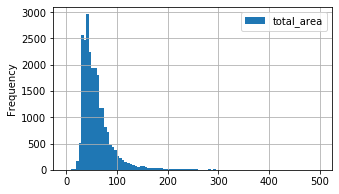

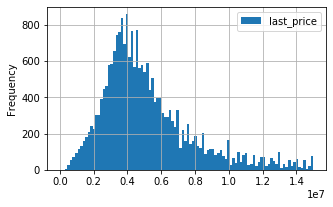

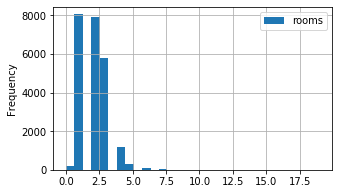

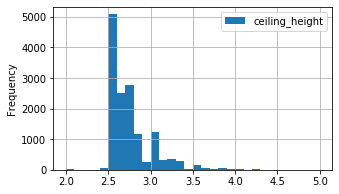

In [0]:
#изучим общую площадь
data
data.plot(y = 'total_area', kind = 'hist', bins = 100, grid=True, figsize = (5,3), range = (0,500))
data['total_area'].describe()
#распределение данных нормальное, есть выбросы но они не сильно влияют на данные, 
#по гистограмме кроме распределения нечего больше указать, с помошью describe получил общее представление

#изучим цену
#data['last_price'] = data['last_price']/1000000
data.plot(y = 'last_price', kind = 'hist', bins = 100, grid=True, range = (0,15000000), figsize = (5,3))
data['last_price'].describe()
#с данными все впорядке но значения выводятся в экспоненциальной записи чисел

#изучим число комнат
data
data.plot(y = 'rooms', kind = 'hist', bins = 30, grid=True, figsize = (5,3))
data['rooms'].describe()
#с данными все впорядке

#изучим высоту потолков
data
data.plot(y = 'ceiling_height', kind = 'hist', bins = 30, range = (2,5), grid=True, figsize = (5,3))
data['ceiling_height'].describe()
#с данными все впорядке


<span style="color:green">Напиши, пожалуйста, чуть подробнее про распределения по параметрам, как в среднем выглядет  площадь квартир, каких больше, что с ценами, как рынок вообще представлен. Представь, что ты словами должен описать распределение,что ты пишешь статью для журнала недвижимости. Представь, что я , например, ничего не знаю о рынке недвижисоти в Санкт-Петербурге, не знаю, какие могут быть цены, площадь, сколько комнат вообще может быть. Попробуй описать рынок для меня :)  </span>

**Вывод:** 
1. Общая площадь в нашей выборке колеблется от 12 до 900 м2, среднее значение 60, а медиана 52 м2. Распределение данных Гаусса.

2. Цены на недвижимость имеют среднее значение в 6,5 млн руб., медиана 4,6 млн руб. Распределение данных Гаусса.

3. Количество комнат колеблется от 1 до 19. Больше всего однокомнатных квартир.

4. Высота потолков в среднем составляет 2,77 м, медиана 2,65 м.

Во всех данных есть неадекватные значения, наподобе 0 комнат, высоты потолков в 1 или 100 метров, а также цена квартиры в 12190 рублей. О данных неадекватных значениях мы спросим у сотрудников, предоставивших нам выборку данных, для общего изучения данных, мы не станем убирать эти выбивающиеся значения.




#### 2. Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?

Прежде чем начать выполнять это задание сделаем предположение, что дата снятия объявления может не считаться датой продажи, причем в непонятном для нас количестве случаев...

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'price_per_square_meter',
       'weekday_exposition', 'month_exposition', 'year_exposition',
       'floor_category', 'useful_area_ratio', 'kitchen_area_ratio'],
      dtype='object')


count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

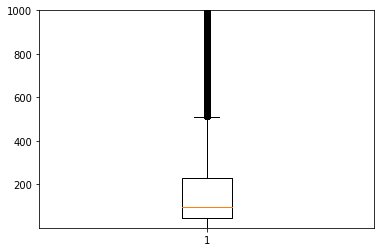

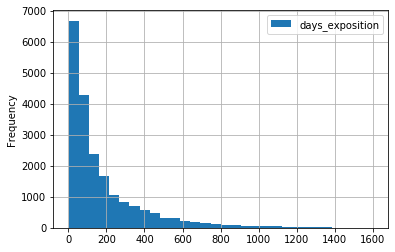

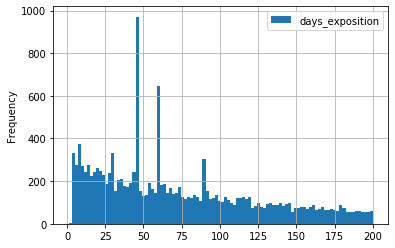

In [0]:
print(data.columns)

#диаграмма размаха
import matplotlib.pyplot as plt
plt.boxplot(data[data['days_exposition']!=0]['days_exposition'])
plt.ylim(1,1000)

data.plot(y = 'days_exposition', kind = 'hist', bins = 30, grid = True, range = (1,1600))
data.plot(y = 'days_exposition', kind = 'hist', bins = 100, grid = True, range = (1,200))

#среднее значение, медиана и межквартильный размах
data[data['days_exposition']!=0]['days_exposition'].describe()
#data[data['days_exposition']!=0]['days_exposition'].value_counts()



**Вывод:** судя по гистограмме - мы имеем распределение Пуассона. Среднее значение - 180 дней, а медиана - 95 дней.
Сделав гистограмму со значениями от 0 до 200 с кол-вом корзин 100, обнаружили выбивающиеся значения и методом value_counts убедились в этом - у нас аномалии на 45, 60, 7, 30, 90 днях - это наиболее популярное количество дней до снятия объявления.

Загуглил правила размещения объявлений в Яндекс Недвижимость, оказалось что именно после этих сроков объявление считается неактуальным и снимается автоматически.
https://yandex.ru/support/realty/owner/home/add-ads-housing.html
Наверное, нам нужно убрать эти значения из выборки, но нужно подумать есть ли еще критерии для снятия таких объявлений, ведь часть из таких квартир могла и правда продаться в этот срок.


In [0]:
data[data['days_exposition']==45]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,weekday_exposition,month_exposition,year_exposition,floor_category,useful_area_ratio,kitchen_area_ratio
78,9,4350000,37.0,2018-02-22,1,NaN,19.0,18.00,6,False,...,0.0,NaN,45,117567,3,2,2018,другой,0.486486,0.289189
89,9,2500000,63.0,2018-10-25,3,2.50,5.0,43.00,4,False,...,NaN,NaN,45,39682,3,10,2018,другой,0.682540,0.142857
110,6,3850000,72.3,2017-09-29,2,NaN,3.0,27.40,2,False,...,NaN,NaN,45,53250,4,9,2017,другой,0.378976,0.326418
153,12,4350000,55.0,2017-05-21,2,2.57,9.0,31.20,2,False,...,0.0,NaN,45,79090,6,5,2017,другой,0.567273,0.150909
158,15,3100000,47.3,2017-11-07,2,NaN,5.0,27.50,2,False,...,NaN,NaN,45,65539,1,11,2017,другой,0.581395,0.179704
166,0,2300000,60.0,2017-12-02,2,NaN,3.0,NaN,1,False,...,NaN,NaN,45,38333,5,12,2017,первый,NaN,NaN
189,0,6150000,62.0,2017-10-13,3,NaN,9.0,41.50,5,False,...,0.0,NaN,45,99193,4,10,2017,другой,0.669355,0.137097
210,4,4300000,58.5,2016-06-15,2,NaN,9.0,28.73,7,False,...,1.0,353.0,45,73504,2,6,2016,другой,0.491111,0.192137
227,13,2200000,47.0,2018-01-12,3,2.34,5.0,NaN,1,False,...,NaN,NaN,45,46808,4,1,2018,первый,NaN,NaN
235,0,4000000,60.0,2019-03-12,2,3.40,3.0,37.80,1,False,...,3.0,534.0,45,66666,1,3,2019,первый,0.630000,0.150000


**Вывод:** никаких общих особенностей в обьявлениях, снятых через 45 дней не выявлено, потому будем убирать эти данные из наших расчетов, как и данные с 60, 90, 30 и 7 дней в столбце days_exposition, так как это аномалии.

До того, как мы очистим наши данные от аномалий, нам нужно дать ответ на вопрос, какое количество дней считать нормальным, а какое выбросом на текущий момент до очистки данных.
Исходя из метода describe, межквартильный размах - от 45 до 232 дней, исходя же из метода boxplot - диаграмма размаха у нас от минимального значения до примерно 500 дней. Значит необоснованно быстрых значений у нас нет, а необоснованно долгие - от 500 дней и выше. Значит нормальные значения у нас лежат от 1 до 500.

На текущий момент мы уже знаем, что эти данные неправильные, но они нам нужны, чтобы сравнить с данными, очищенными от аномалий далее.

Считаю важным уточнить у сотрудников насчет выбивающихся значений по датам снятия объявлений, чтобы убедиться в том, какие данные необходимо исключить из выборки.

<span style="color:green">Тут вообще интересная картина, помнишь мы долбались с этим 45??)) По-моему, что-то с ними не чисто, с этими датами :D Я бы уточнила у ребят, которые собирают данные)</span>

#### 3. Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили.

count    18454.000000
mean       195.803349
std        226.760010
min          1.000000
25%         44.000000
50%        114.000000
75%        259.000000
max       1580.000000
Name: days_exposition, dtype: float64

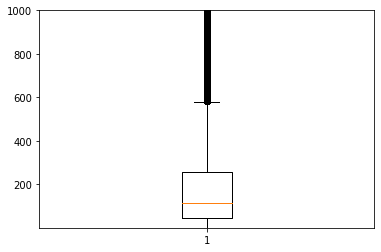

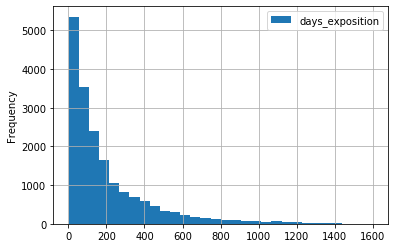

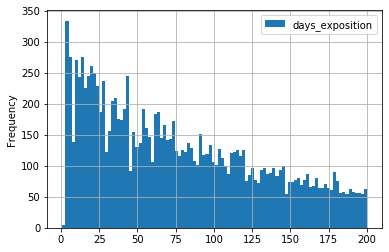

In [0]:
#отфильтруем данные от аномалий и запишем их в новый датафрейм good_data
good_data = data.query('days_exposition != 45 and days_exposition != 30 and days_exposition != 60 and days_exposition != 90 and days_exposition != 7 and days_exposition != 0')

#диаграмма размаха
plt.boxplot(good_data['days_exposition'])
plt.ylim(1,1000)

#гистограммы
good_data.plot(y = 'days_exposition', kind = 'hist', bins = 30, grid = True, range = (1,1600))
good_data.plot(y = 'days_exposition', kind = 'hist', bins = 100, grid = True, range = (1,200))

#среднее значение, медиана и межквартильный размах
#good_data['days_exposition'].value_counts()
good_data['days_exposition'].describe()


Вывод: ожидаемо, в очищенных данных с аномалиями в значениях меньших медианы получаем бОльшие значения медианы и среднего значения - 114 и 195 соответственно, вместо 95 и 180. Аналогично, теперь нормальные значения располагаются от 1 до 600 дней вместо от 1 до 500 дней.

#### 4. Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена квадратного метра от общей площади квартиры, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года.

**Изучим зависимость цены квадратного метра от общей площади квартиры.**

0.30196014387792547

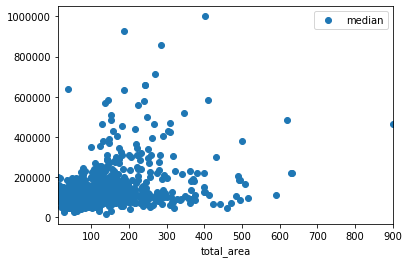

In [0]:
pivot_table_total_area = data.pivot_table(index = 'total_area', values = 'price_per_square_meter', aggfunc = ['mean', 'count', 'median'])
pivot_table_total_area.columns = ['mean', 'count', 'median']
pivot_table_total_area.plot(y = 'median', style = 'o')

pivot_table_total_area.sort_values('median', ascending = False)

data['total_area'].corr(data['price_per_square_meter'])

**Вывод:** видим, что зависимость очень слабая - согласно корреляции Пирсона - 0.3! То есть, чем больше площадь тем немного выше стоимость!

**Изучим зависимость цены квадратного метра от числа комнат.**

0.0554194996705922

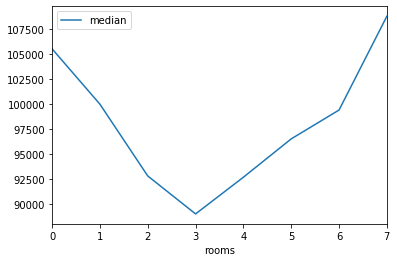

In [0]:
pivot_table_rooms = data.pivot_table(index = 'rooms', values = 'price_per_square_meter', aggfunc = ['mean', 'count', 'median'])
pivot_table_rooms.columns = ['mean', 'count', 'median']
pivot_table_rooms.query('count > 50').plot(y = 'median')

pivot_table_rooms.query('count > 50').sort_values('median', ascending = False)

data['rooms'].corr(data['price_per_square_meter'])

**Вывод:** чем ближе количество комнат к 3 тем ниже стоимость квадратного метра.

**Изучим зависимость цены квадратного метра от этажа (первого или последнего).**

,mean,count,median
floor_category,,,
первый,81983.111759,2917,81223
последний,93410.267686,3336,87777


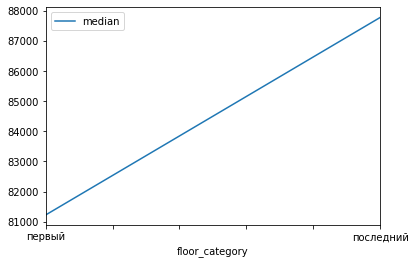

In [0]:
pivot_table_floor_category = data.query('floor_category != "другой"').pivot_table(index = 'floor_category', values = 'price_per_square_meter', aggfunc = ['mean', 'count', 'median'])
pivot_table_floor_category.columns = ['mean', 'count', 'median']
pivot_table_floor_category.plot(y = 'median')
pivot_table_floor_category

**Вывод:** из графика ничего не понятно! Согласно медиане - как правило квартиры на первом этаже дешевле квартир на последнем этаже - в среднем на 10%!

**Изучим зависимость цены квадратного метра от удалённости от центра.**

-0.3179507368286467

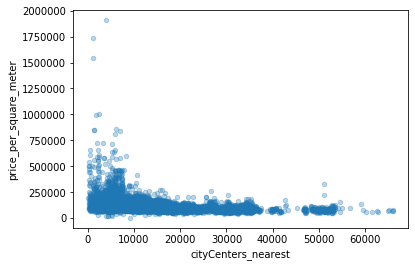

In [0]:
data.plot(kind = 'scatter', y = 'price_per_square_meter', x = 'cityCenters_nearest', alpha = 0.3)

data['cityCenters_nearest'].corr(data['price_per_square_meter'])

**Вывод:** видим явную зависимость стоимости квадратного метра от близости к центру! Чем ближе к центру, тем выше стоимость!

**Изучим зависимость цены квадратного метра от даты размещения: дня недели.**

,mean,count,median
weekday_exposition,,,
1,99734.089410,4183,95634.0
2,99616.731002,3974,95473.0
3,100162.466356,4295,95143.0
0,99437.994463,3612,94688.0
4,99011.697000,4000,94616.0
6,97707.917010,1699,94501.0
5,99017.722107,1936,93545.5


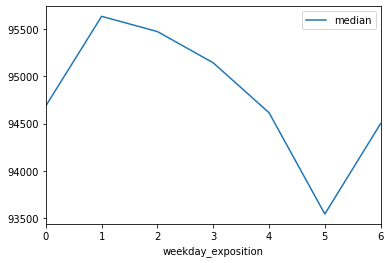

In [0]:
pivot_table_weekday_exposition = data.pivot_table(index = 'weekday_exposition', values = 'price_per_square_meter', aggfunc = ['mean', 'count', 'median'])
pivot_table_weekday_exposition.columns = ['mean', 'count', 'median']
pivot_table_weekday_exposition.plot(y = 'median')

pivot_table_weekday_exposition.sort_values('median', ascending = False)

**Вывод:** видим, что чем ближе ко вторнику выставлены объявления тем в среднем выше стоимость, но незначительно! По субботам стоимость самая низкая!

Полагаю, что стоимость выставленной на продажу недвижимости зависит от общей активности людей, так как именно в рабочие дни мы видим более высокие цены.

<span style="color:green">С чем это связано? Можешь тут порассуждать немного?))</span>

**Изучим зависимость цены квадратного метра от даты размещения: месяца.**

,mean,count,median
month_exposition,,,
4,101948.567045,2379,96451
8,100110.094037,1744,96026
9,100463.814740,1981,95607
11,99230.427246,2371,95588
3,98972.768844,2587,95238
1,99862.139333,1500,95222
2,98768.292045,2640,95000
7,99625.190560,1695,95000
12,99574.280926,1641,94262


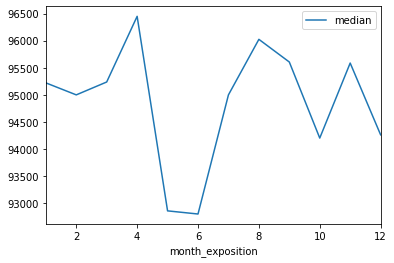

In [0]:
pivot_table_month_exposition = data.pivot_table(index = 'month_exposition', values = 'price_per_square_meter', aggfunc = ['mean', 'count', 'median'])
pivot_table_month_exposition.columns = ['mean', 'count', 'median']
pivot_table_month_exposition.plot(y = 'median')

pivot_table_month_exposition.sort_values('median', ascending = False)

**Вывод:** самая высокая стоимость метра в апреле и августе! Самая низкая стоимость в мае и июне!
На рынке недвижимости, как и во многих других сферах присутствует сезонность - в начале лета мы видим наименьшее предложение как по количеству, так и по стоимости недвижимости. Наверное, это связано с отпусками.

<span style="color:green">А на что тут рассчитывают люди, которые выставляют недвижимость? Писуща ли рунку недвижимости сезонность? Какая?</span>

**Изучим зависимость цены квадратного метра от даты размещения: года.**

,mean,count,median
year_exposition,,,
2014,124830.000000,137,107000.0
2019,107123.332060,2879,103305.0
2018,97773.107290,8519,95689.0
2015,104613.756507,1191,93414.0
2017,97621.434188,8190,92564.5
2016,98321.900467,2783,91743.0


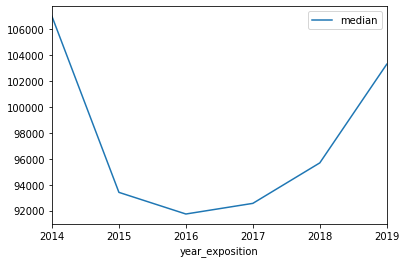

In [0]:
pivot_table_year_exposition = data.pivot_table(index = 'year_exposition', values = 'price_per_square_meter', aggfunc = ['mean', 'count', 'median'])
pivot_table_year_exposition.columns = ['mean', 'count', 'median']
pivot_table_year_exposition.plot(y = 'median')

pivot_table_year_exposition.sort_values('median', ascending = False)

**Вывод:** видим, что с 2014 до 2016 года цена падала, но далее начала увеличиваться! В СРЕДНЕМ! Мы не рассматриваем сегментацию рынка и по факту стоимость аналогичных квартир могла себя вести абсолютно иначе от года к году!
В выводе присутствует реальный пример.

<span style="color:green">Вот тут можно было включить свои рассуждения) Они мне очень понравились и я считаю, что они должны быть в твоем исследовательском анализе :)</span>

#### 5. Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце 'locality_name'.

In [0]:
locality_pivot_table = data.pivot_table(index = 'locality_name', values = 'price_per_square_meter', aggfunc=['count', 'mean'])
locality_pivot_table.columns = ['count', 'mean']
locality_pivot_table = locality_pivot_table.sort_values('count', ascending = False).head(10)
locality_pivot_table
#самая высокая стоимость
locality_pivot_table[locality_pivot_table['mean']==locality_pivot_table['mean'].max()]
#самая низкая стоимость
locality_pivot_table[locality_pivot_table['mean']==locality_pivot_table['mean'].min()]


,count,mean
locality_name,,
Выборг,237,58141.489451


**Вывод:** самая высокая стоимость жилья из 10 населённых пунктов с самым большим количеством объявлений в Санкт-Петербурге, тогда как самая низкая стоимость в Выборге.

#### 6. Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге ('locality_name'). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона.

,price_per_square_meter
cityCenters_nearest_km,
0,187323.674419
1,166603.312500
2,146662.420195
3,129415.891635
4,137475.039691
5,146978.789337
6,152277.455319
7,141399.287469
8,120580.929851


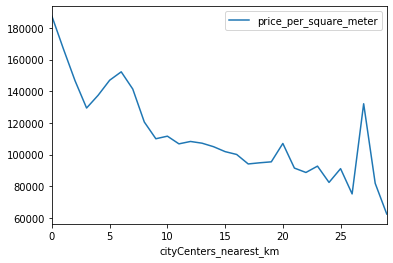

In [0]:
data['cityCenters_nearest_km'] = data['cityCenters_nearest']/1000
data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].fillna(999999)
data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].astype('int')
pivot_table_km = data.query('locality_name == "Санкт-Петербург" and cityCenters_nearest_km !=999999').pivot_table(index = 'cityCenters_nearest_km', values = 'price_per_square_meter', aggfunc = 'mean')
pivot_table_km.plot()
pivot_table_km

**Вывод:** судя по графику центром считать будем радиус в 3 километра!

<span style="color:green">Не мало ли для Питера О_о</span>

#### 7. Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?

In [0]:
#выделим квартиры в центре, беря за радиус 3 км
center_spb_data = data.query('cityCenters_nearest_km <= 3 and locality_name == "Санкт-Петербург"')

**Зависимость стоимости квадратного метра от количества комнат.**

0.0017673487141106456

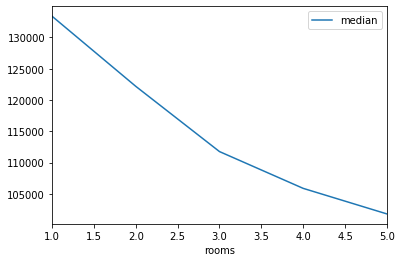

In [0]:
center_spb_rooms = center_spb_data.pivot_table(index = 'rooms', values = 'price_per_square_meter', aggfunc = ['mean', 'count', 'median'])
center_spb_rooms.columns = ['mean', 'count', 'median']
center_spb_rooms.query('count > 50').plot(y = 'median')

center_spb_rooms.query('count > 50').sort_values('median', ascending = False)

center_spb_data['rooms'].corr(center_spb_data['price_per_square_meter'])

**Вывод:** в центре СПБ чем меньше комнат тем дороже стоимость метра квадратного, в отличие от всей выборки, где стоимость уменьшается в зависимости от близости кол-ва комнат к 3! Так мы считаем, исходя из поведения медианной стоимости, в зависимости от количества комнат. Хотя корреляция маленькая, правильнее смотреть именно на график.

<span style="color:green">Посмотри какой коэффициент корреляции, он же мизерный) Разве можем судить о связи?</span>

**Зависимость стоимости квадратного метра от этажа.**

,mean,count,median
floor_category,,,
первый,123509.146341,164,107508.5
последний,146998.742537,268,114432.0


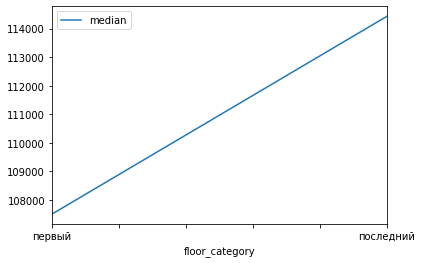

In [0]:
center_spb_floor_category = center_spb_data.query('floor_category != "другой"').pivot_table(index = 'floor_category', values = 'price_per_square_meter', aggfunc = ['mean', 'count', 'median'])
center_spb_floor_category.columns = ['mean', 'count', 'median']
center_spb_floor_category.plot(y = 'median')
center_spb_floor_category

**Вывод:** нет особых отличий от всей выборки квартир! Квартиры на первом этаже в среднем дешевле, чем на последнем!

**Зависимость стоимости квадратного метра от удаленности от центра.**

-0.16437506633061943

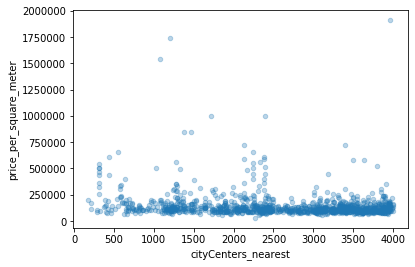

In [0]:
center_spb_data.plot(kind = 'scatter', y = 'price_per_square_meter', x = 'cityCenters_nearest', alpha = 0.3)

center_spb_data['cityCenters_nearest'].corr(center_spb_data['price_per_square_meter'])

**Вывод:** ожидаемо, четкой зависимости нет, так как у нас уже сделана выборка по центру города!

**Зависимость стоимости квадратного метра от дня недели размещения объявления.**

,mean,count,median
weekday_exposition,,,
0,145551.070588,170,121354.0
5,161508.078947,76,120568.0
4,139252.674528,212,117984.0
2,144332.984536,194,114902.5
1,148325.074074,189,114209.0
6,143555.014925,67,110843.0
3,147413.011952,251,110132.0


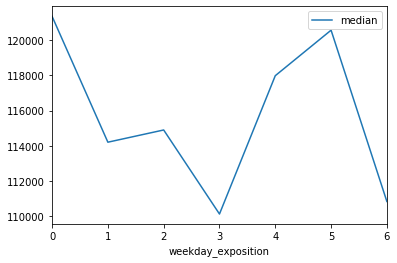

In [0]:
center_spb_weekday_exposition = center_spb_data.pivot_table(index = 'weekday_exposition', values = 'price_per_square_meter', aggfunc = ['mean', 'count', 'median'])
center_spb_weekday_exposition.columns = ['mean', 'count', 'median']
center_spb_weekday_exposition.plot(y = 'median')

center_spb_weekday_exposition.sort_values('median', ascending = False)

**Вывод:** ситуация отличается от всей выборки, минимальные средние цены в четверг и воскресенье, самые высокие - в понедельник и субботу!

<span style="color:green">Классно, что везде ссылаешься на общую выборку :)</span>

**Зависимость стоимости квадратного метра от месяца размещения объявления.**

,mean,count,median
month_exposition,,,
4,168982.870690,116,123094.5
10,143129.021277,94,121978.0
12,162849.843373,83,121568.0
3,149574.508475,118,117409.0
1,147760.090909,77,117244.0
2,141960.713178,129,116406.0
9,155581.594059,101,116054.0
11,136308.390244,123,112639.0
7,137694.565657,99,112195.0


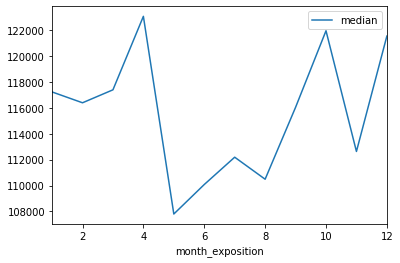

In [0]:
center_spb_month_exposition = center_spb_data.pivot_table(index = 'month_exposition', values = 'price_per_square_meter', aggfunc = ['mean', 'count', 'median'])
center_spb_month_exposition.columns = ['mean', 'count', 'median']
center_spb_month_exposition.plot(y = 'median')

center_spb_month_exposition.sort_values('median', ascending = False)

**Вывод:** ситуация похожая с общей выборкой - самая высокая стоимость метра в апреле и августе! Самая низкая стоимость в мае и июне!

**Зависимость стоимости квадратного метра от года размещения объявления.**

,mean,count,median
year_exposition,,,
2019,173593.070866,127,131432
2018,140129.402941,340,117898
2017,141410.263158,418,114579
2016,135592.863946,147,109090
2015,154054.330508,118,107055


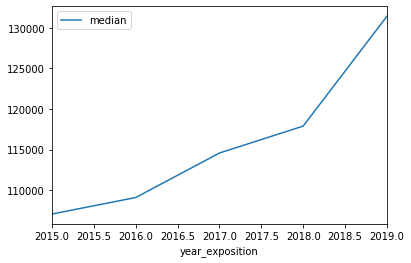

In [0]:
center_spb_year_exposition = center_spb_data.pivot_table(index = 'year_exposition', values = 'price_per_square_meter', aggfunc = ['mean', 'count', 'median'])
center_spb_year_exposition.columns = ['mean', 'count', 'median']
center_spb_year_exposition.query('count > 50').plot(y = 'median')

center_spb_year_exposition.query('count > 50').sort_values('median', ascending = False)

**Вывод:** в отличие от всей выборки - цены в центре СПБ в 2016-2017 годах не падали, а планомерно расли!

### Шаг 5. Общий вывод

Мы обработали полученный архив данных - обработали пропущенные значения там, где это необходимо, заменили типы данных на необходимые для удобной работы.
Посчитали и добавили в таблицу цену квадратного метра жилья, вывели из даты дни недели, месяцы и года размещения объявлений, добавили категории по этажам квартир. Изучили следующие параметры на наличие выбивающихся значений - площадь, цена, число комнат, высота потолков. Были определены аномалии в данных параметрах. Изучая время продажи квартир мы выявили, что большое количество объявлений было автоматически снято с Яндекс Недвижимость и дату из снятия нельзя считать датой продажи квартиры, поэтому, изучая средние сроки продажи квартир - данные значения не учитывались.  Мы выявили при помощи диаграммы размаха, что нормальные значения продажи квартир варьируются от 1 до 600 дней.
Мы выявили, что на стоимость квадратного метра квартиры больше всего влияют количество комнат, этаж квартиры, близость к центру. Незначительно на стоимость квадратного метра влияют день, месяц, год размещения и общая площадь. Нужно учитывать, что в 2016-2017 годах стоимость квартир в среднем по рынку была ниже на 10-20 %, тогда как в центре Санкт-Петербурга данной зависимости от года не обнаружено.  В данном случае имело место постоянное удорожание стоимости, начиная с 2015 года по текущий момент. Судя, по резкости изменения цен в зависимости от удаления от центра СПБ, мы выявили центр города в радиусе 3 километров.

Также важно учитывать, что, рассматривая среднюю стоимость квартир в 2014-2019 годах, мы не делали сегментацию рынка, а лишь смотрели средние показатели по рынку в целом. Т.е. возможно, что цены на аналогичные квартиры в разных годах вели себя абсолютно по-разному. Т.е. например в то время, когда средняя стоимость метра по рынку в 2016-2017 годах была наиболее низкой, какие-то аналогичные прошлым годам квартиры могли и не падать в цене, а наоборот дорожать! Именно об этом нам и говорят данные, полученные при изучении единственного сегмента квартир - находящихся в радиусе 3 км в центре СПБ. 

### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод info())
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения
- [x]  есть пояснение какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение в каких столбцах изменены типы и почему
- [x]  посчитано и добавлено в таблицу: цена квадратного метра
- [x]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [x]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [x]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [x]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"
- [x]  выполнено задание: "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."
- [x]  выполнено задание: "Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. "Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце '*locality_name'*. "
- [x]  выполнено задание: "Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (*'locality_name'*). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона. "
- [x]  выполнено задание: "Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод